In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from res.plot_lib import plot_data, plot_model

# INF554: Lab 7

# Introduction to PyTorch and Convolutional Neural Networks

In this lab we will learn to use <a href="https://pytorch.org/">PyTorch</a> to build more complex neural networks, such as Convolutional Neural Networks.

The fondamental data structure in PyTorch are <a href="https://pytorch.org/docs/stable/tensors.html#torch.Tensor">Tensors</a>. If you are familiar with Numpy arrays, you will find it easy to adapt to work with tensors. You may also take a look at the [tensor_tutorial](extras/tensor_tutorial.ipynb) for some examples.

Let's generate some data:

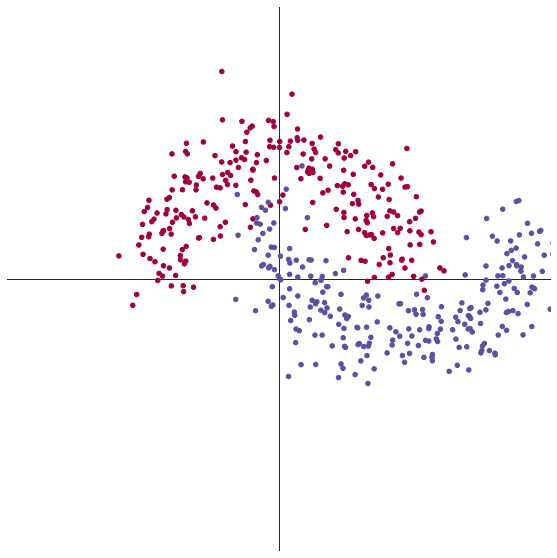

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #if you have a GPU with CUDA installed, this may speed up computation

#let's generate some data
X, Y = make_moons(n_samples=500, noise=.2)

plot_data(torch.from_numpy(X).float(), torch.from_numpy(Y).long(), zoom=2)


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.3)

#we need to convert the data from Numpy arrays to Tensors
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
Y_train = torch.from_numpy(Y_train).long().to(device)
Y_test = torch.from_numpy(Y_test).long().to(device)


## A first model

As a first exercise, we will re-implement the NN that we created for Lab6 using PyTorch. We have seen that the fundamental blocks of NNs are *layers*. PyTorch provides various implementations for a great number of widely used layers. For instance, to apply a linear transformation:

`nn.Linear(input_size, output_size, bias=True)`

The layers are organized into <a href="https://pytorch.org/docs/stable/nn.html#containers">Containers</a>. A standard and flexible container is the <a href="https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module">Module</a> container. However, if we need a simple sequential network and don't need to reference the different layers, we can use the simplified <a href="https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential">Sequential</a> container.

> **Task 1.** Implement a sequential model with an input size of 2, a hidden layer of 16 units with ReLU activation, Softmax output.

In [4]:
n_hunits=16
#INSERT YOUR CODE HERE
model = nn.Sequential(
    nn.Linear(2, n_hunits, bias=True),
    nn.Tanh(),
    nn.Linear(n_hunits, 2, bias=True),
    #nn.Softmax(1)
)


Now we choose the *loss* function and the *optimizer* and we start training our model.
Take a look at the various <a href="https://pytorch.org/docs/stable/optim.html">optimizers</a> and <a href="https://pytorch.org/docs/stable/nn.html#loss-functions">loss</a> functions available in Torch.

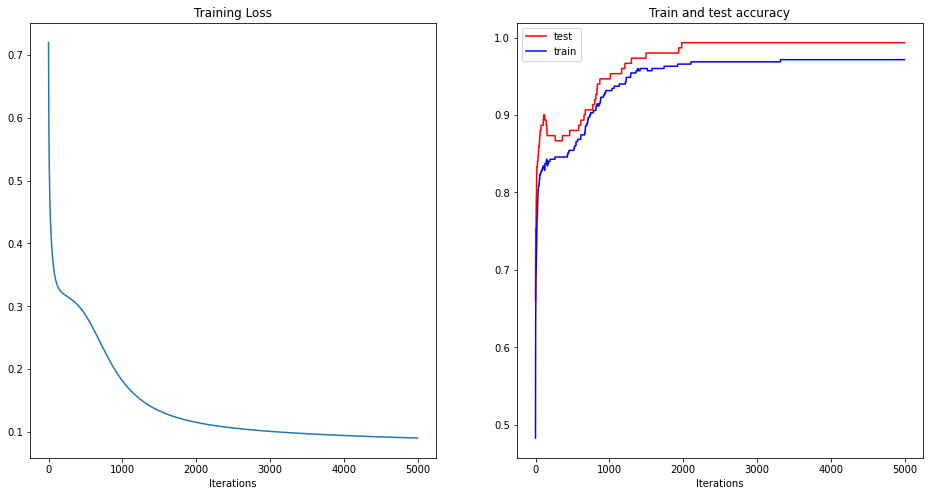

In [5]:
model.to(device) #if you have CUDA, this will make computation faster

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #actually SGD is just GD in this case

#init performance measures
losses = []
tr_acc = []
test_acc = []

for epoch in range(5000):
    output=model.forward(X_train)
    loss = loss_function(output, Y_train)
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    #update loss and accuracy
    losses.append(loss.data)
    output_te=model(X_test)
    tr_acc.append(accuracy_score(Y_train.cpu(), torch.max(output.cpu(), 1)[1]))
    test_acc.append(accuracy_score(Y_test.cpu(), torch.max(output_te.cpu(), 1)[1]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")
ax2.plot(test_acc, c='r', label='test')
ax2.plot(tr_acc, c='b', label='train')
ax2.set_title("Train and test accuracy")
ax2.set_xlabel("Iterations")
plt.legend()
plt.show()

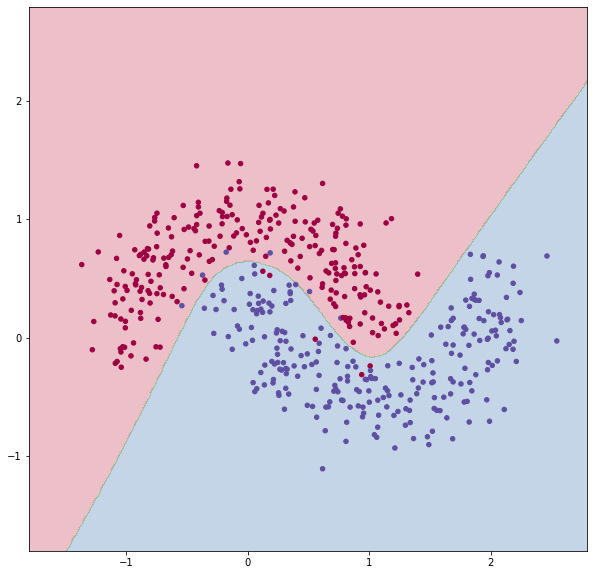

In [6]:
plot_model(torch.from_numpy(X).float(), torch.from_numpy(Y).long(), model)

> **Task 2.** (a) Run the experiment again, modifying the number of units (try 8 and 32), and compare with the results seen in Lab 6. (b) modify the activation function as tanh. (c) Modify the learning rate to 0.01 and observe the results with different number of units.

## Classifying Images

For the next tasks we will load the MNIST dataset:

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset_tr = datasets.MNIST('./data', train=True, download=False, transform=transform)
dataset_te = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset_tr,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_te, batch_size=1000,shuffle=True)

#load training data
images, labels = next(iter(train_loader))

Let's take a look at the data:

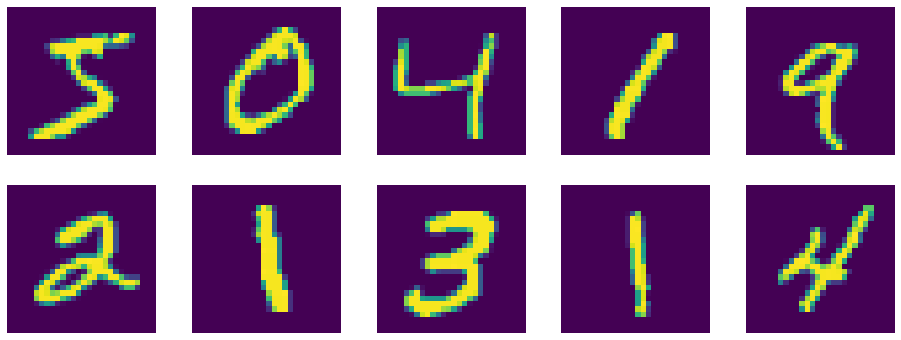

In [4]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

> **Task 3**: implement a fully connected NN with 2 relu activation layers. Note that the image size is 28x28 but you will need to reshape it as a vector of 784 elements.
For the output layer, we will use log_softmax and for the loss, we will use the negative log-likelihood loss (nll_loss), both for numerical stability


In [5]:
import torch.nn.functional as F

class FCNN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCNN, self).__init__()
        #TODO: insert your code here
        self.input_size=input_size
        self.linear1=nn.Linear(input_size, n_hidden)
        self.linear2=nn.Linear(n_hidden, n_hidden)
        self.linear3=nn.Linear(n_hidden, output_size)
        

    def forward(self, x):
        #TODO: insert your code here
        #print("before view", x.size())
        x = x.view(-1, self.input_size) #x:[64, 1, 28,28] after this: [64, 784]
        #print("after view", x.size())
        x=self.linear1(x)
        #print("after fc1", x.size())
        x=F.relu(x)
        x=self.linear2(x)
        x=F.relu(x)
        x=self.linear3(x)
        output=F.log_softmax(x, dim=1)
        return output

In [6]:

def train(model, device, train_loader, optimizer, epoch):
    log_interval=100
    model.train() #set model in train mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        #TODO: introduce the loss here
        loss = F.nll_loss(output, target)
        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval() #set model in test mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Let's take a look at the loss and accuracy of our FCNN:

In [14]:
n_hidden = 10 # number of hidden units

model_fnn = FCNN(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 1):
    train(model_fnn, device, train_loader, optimizer, epoch)
    test(model_fnn, device, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298952
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.719831
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.055622
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.083181
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.743676
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.538544
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.634036
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.490567
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.383833
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.686961

Test set: Average loss: 0.4048, Accuracy: 8851/10000 (89%)



Let's see visualize how different units react to the input; in particular, the following code is useful to show the activations of each unit with respect to the input class. We are going to look in particular into the output of layer 2.

A note about how LayerActivations works: it is based on pytorch *hooks*. Hooks are used for inspecting / modifying the output and the gradients of a layer. Hooks can be registered on a Module or a Tensor.The hook can be a forward hook or a backward hook. The forward hook will be executed when a forward call is executed. The backward hook will be executed in the backward phase. In our case we use a forward hook to visualize the output of a layer.

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.5839,
         0.0000,  0.0000])
-1.5839462280273438
tensor(7)


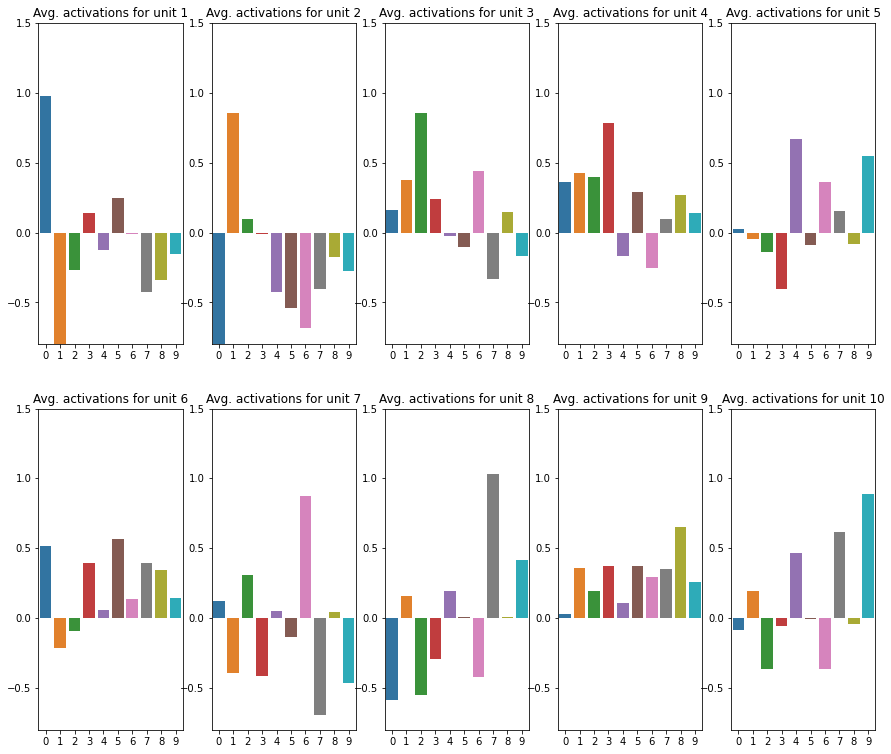

In [25]:
class LayerActivations():
    #to look into the layers and register the activation values
    features=None #the activation values
    
    def __init__ (self, model_layer):
        #model_layer: the layer to be monitored
        self.hook = model_layer.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
        
    def remove(self): #call this once you've read the values
        self.hook.remove()

def getActivations(model, model_layer, images):
    """Input:
      model: (nn.Module) the model from which we need to visualize layers
      model_layer: (nn.Module) the layer to be visualized
      images: tensor of size [n_images, channel, img_x, img_y]
    Output:
      activations
    """
    conv_out = LayerActivations(model_layer)
    o = model(images)
    act = conv_out.features
    conv_out.remove()
    return act

for images, targets in test_loader:
    act=getActivations(model_fnn, model_fnn.linear3, images.to(device))
    
    M=torch.zeros([n_hidden, 10, 1000], dtype=torch.float32)
    for u in range(n_hidden):
        for i in range(1000):
            M[u][targets[i].data][i]=act[i][u].item()
    
    A=torch.mean(M, dim=2)
    print(M[0,:,0])
    print(act[0][0].item())
    print(targets[0])
    
    plt.figure(figsize=(15,13))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        ax=sns.barplot(data=A[i])
        ax.set(ylim=(-0.8, 1.5))
        plt.title("Avg. activations for unit "+str(i+1))
    
    plt.show()
    break #no need to go further, we are testing so the activations won't change
    

## Convolutional Neural Networks

Let's see if we can do better: with images, convolutional layers are more efficient than Dense layers since they can capture local information in the images. See also <a href="https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks">this page</a> for a more complete overview of CNNs.

>**Task 4:** implement a CNN with 2 <a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html">convolutional layers</a> each followed by a <a href="https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html">max pooling</a> layer (kernel_size=2). Complete the network with 2 fully connected layers, where the final layer has 50 input units (and 10 outputs, one for each class). Kernel size for the convolutional layers will be 5.

If you use the default options for stride (1) and padding (0), the image width and height after each convolution will change as follows: $W'=W-(K-1)$, where $K$ stands for the kernel size.



In [17]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        #insert your code here
        K=5 #Kernel size
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=K)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=K)
        self.fc1 = nn.Linear(n_feature*4*4, 50) #the size of the vector of features comes from the size of the final features after all the convolutional layer have been applied
        self.fc2 = nn.Linear(50, 10)
        
        
    def forward(self, x, verbose=False):
        #initial dimensions for x will be [64, 1, 28, 28]
        #insert your code here
        x = self.conv1(x) #[64, 6, 24, 24]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #[64, 6, 12, 12]
        x = self.conv2(x) #[64, 6, 8, 8]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #[64, 6, 4, 4]
        x = x.view(-1, self.n_feature*4*4) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [15]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 1):
    train(model_cnn, device, train_loader, optimizer, epoch)
    test(model_cnn, device, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.319066
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.605717
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.650194
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.527437
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.301646
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.155670
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.198345
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.215896
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.448661
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.113802

Test set: Average loss: 0.1797, Accuracy: 9403/10000 (94%)



> **Task 5**: visualize the feature maps for the two convolution layers; use the `getActivations` function that we introduced above.

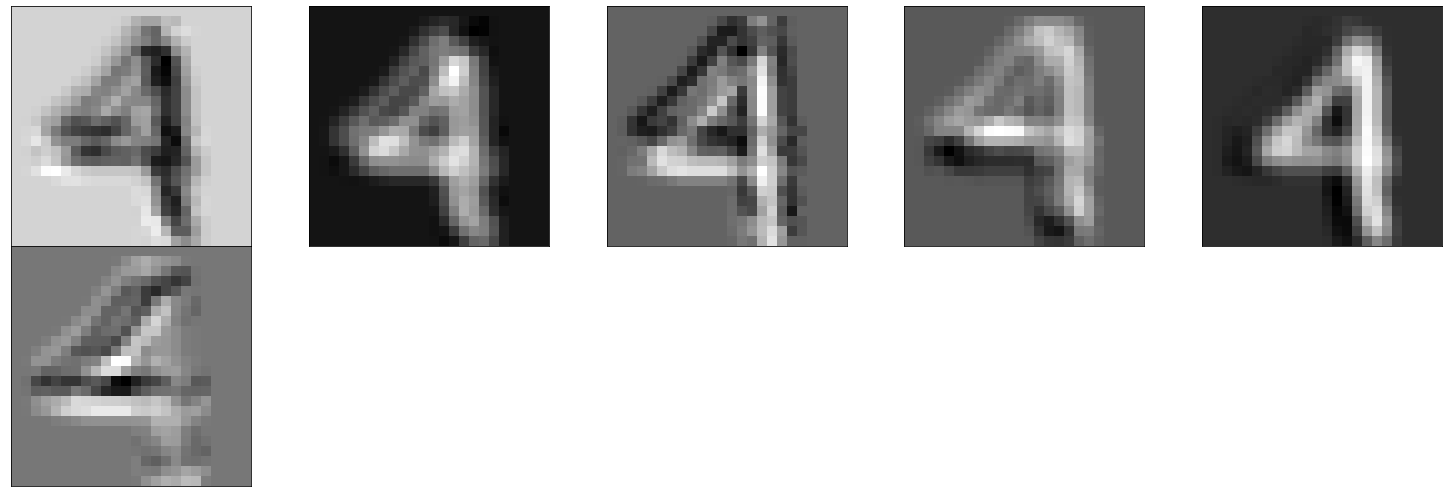

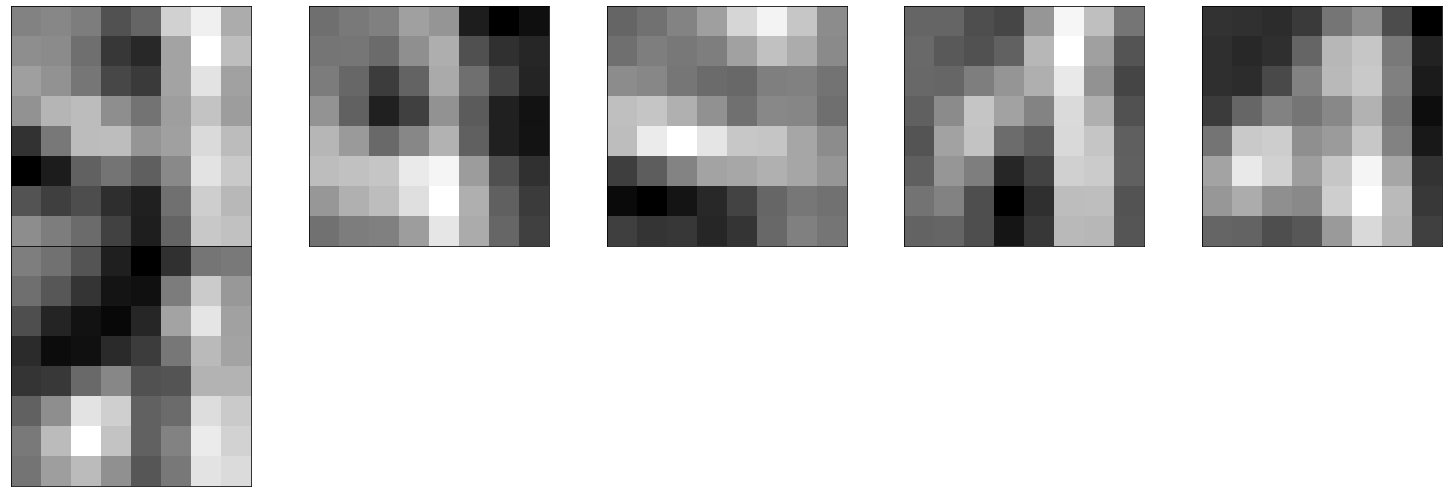

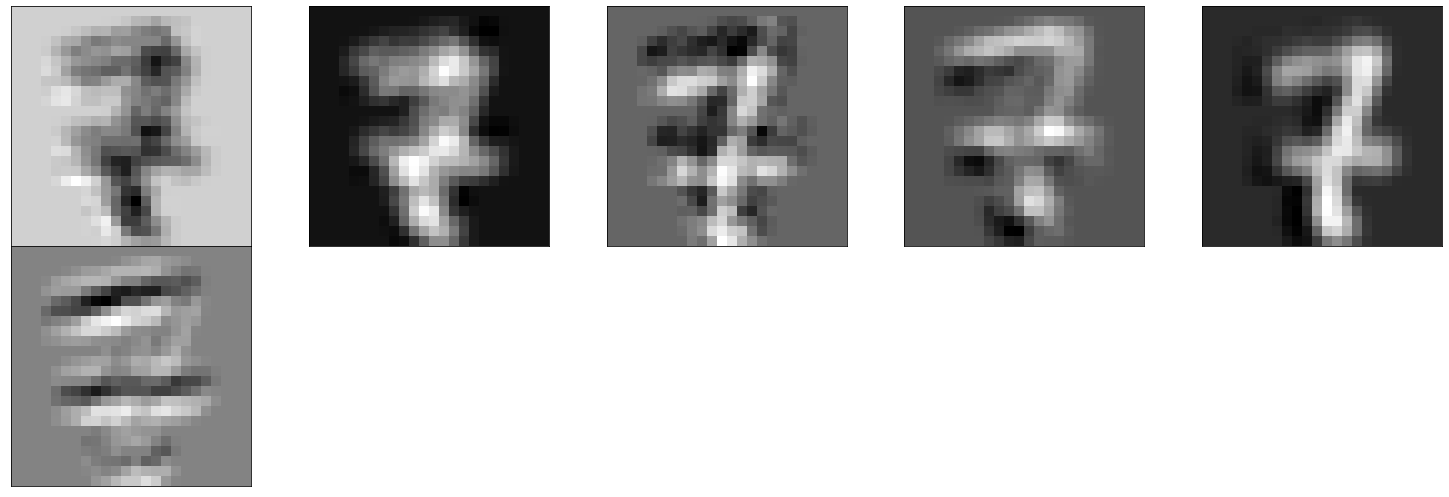

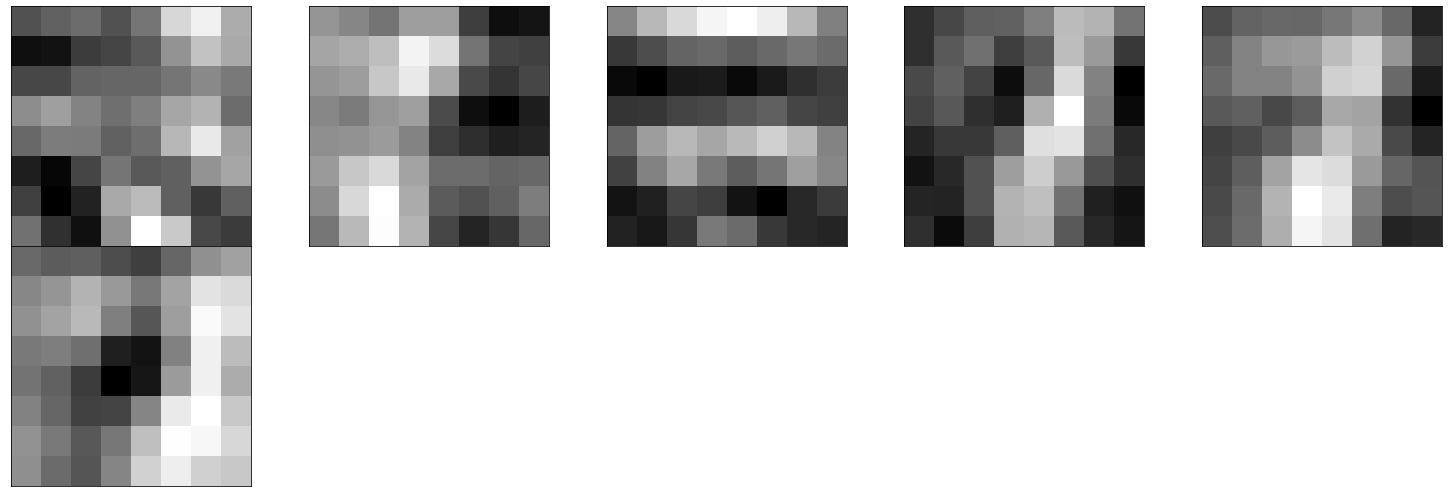

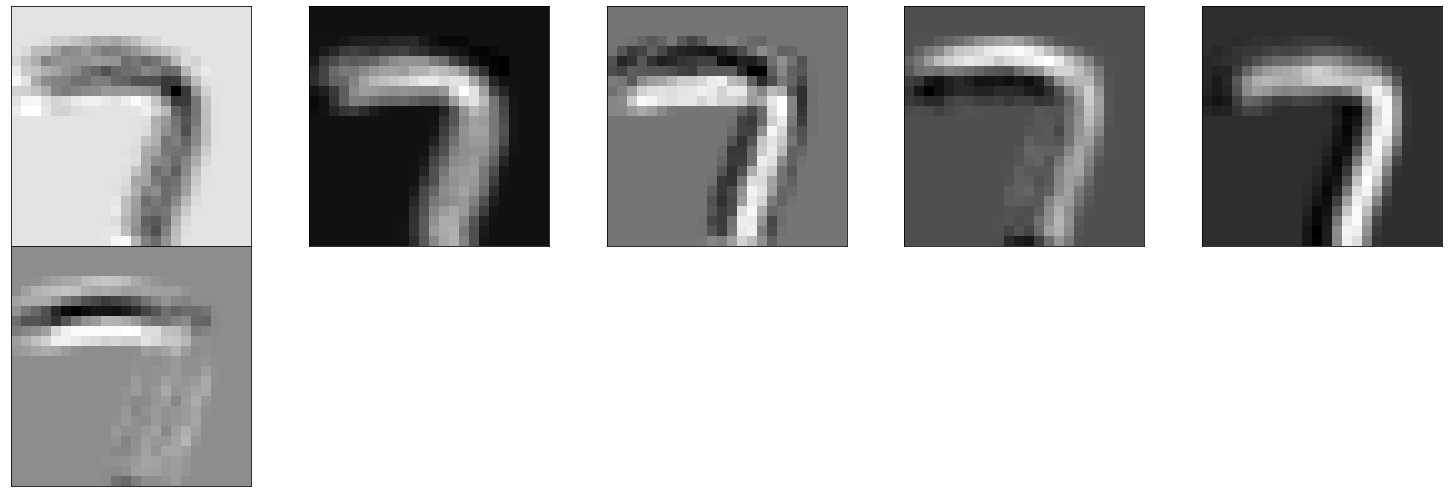

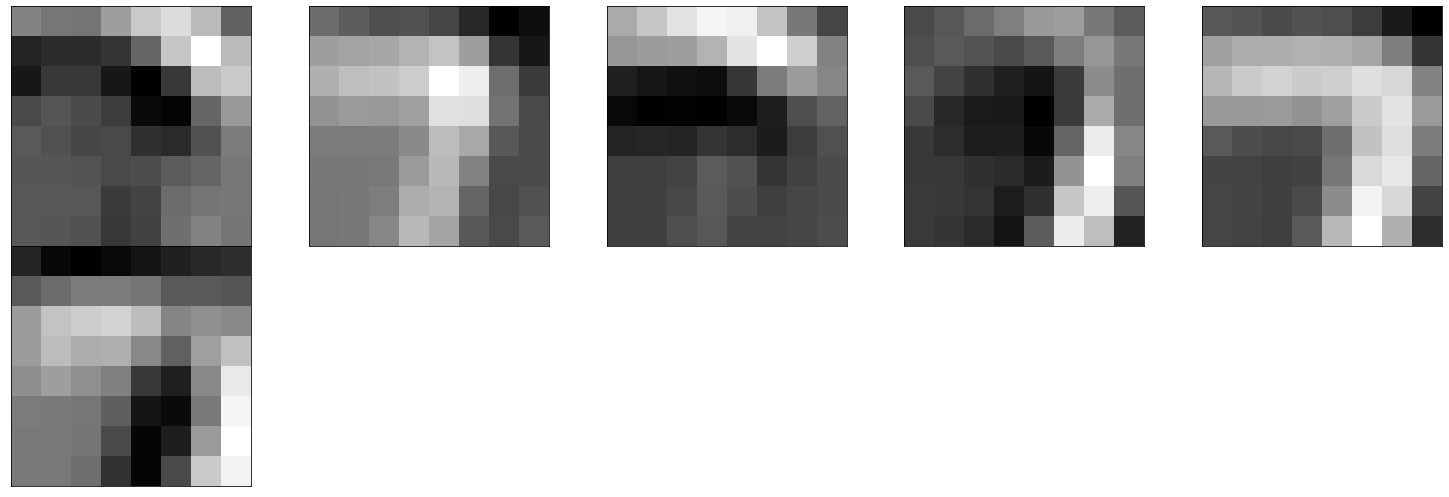

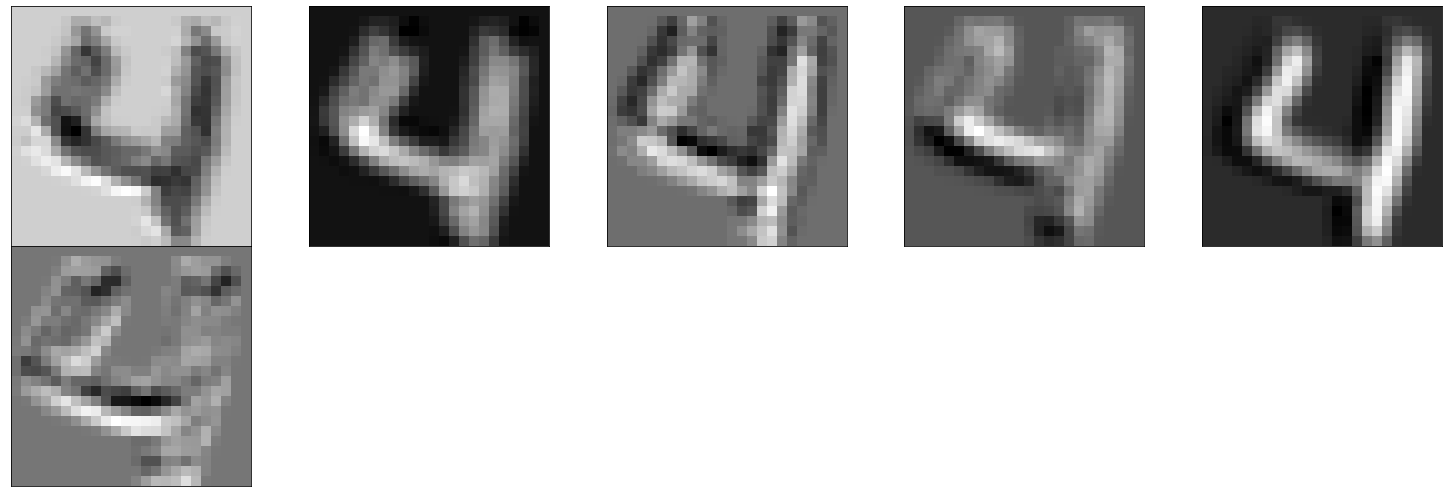

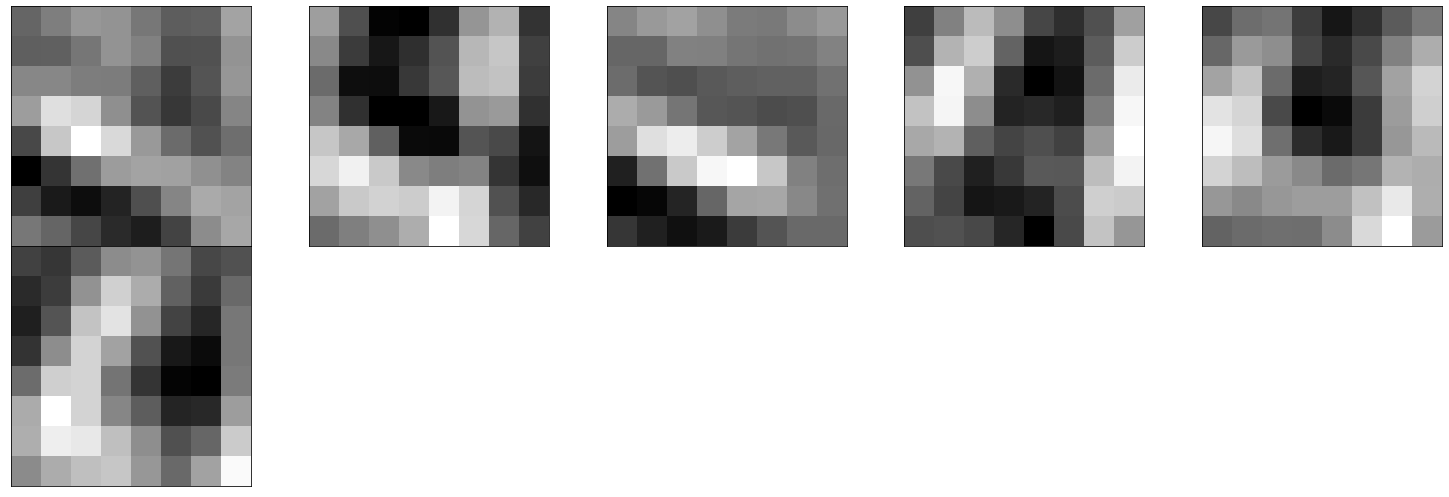

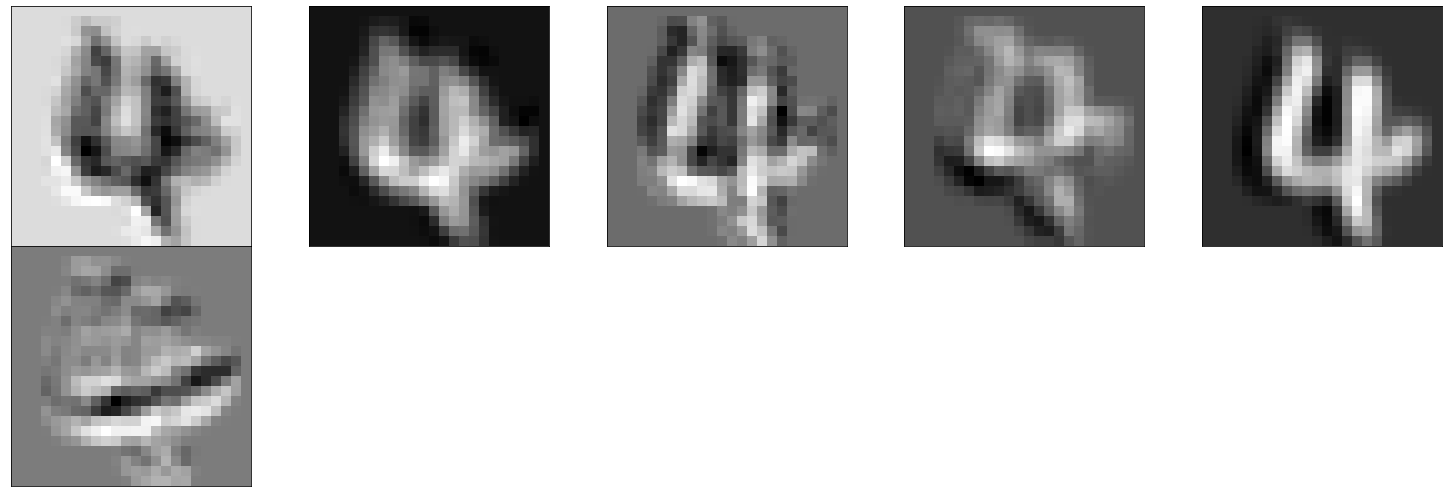

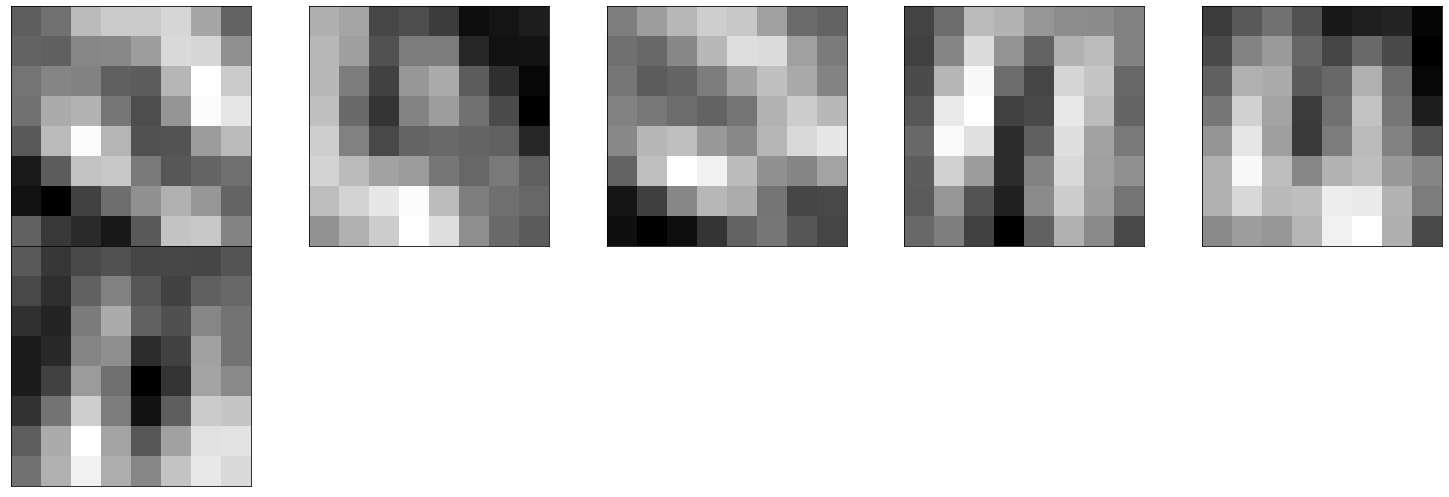

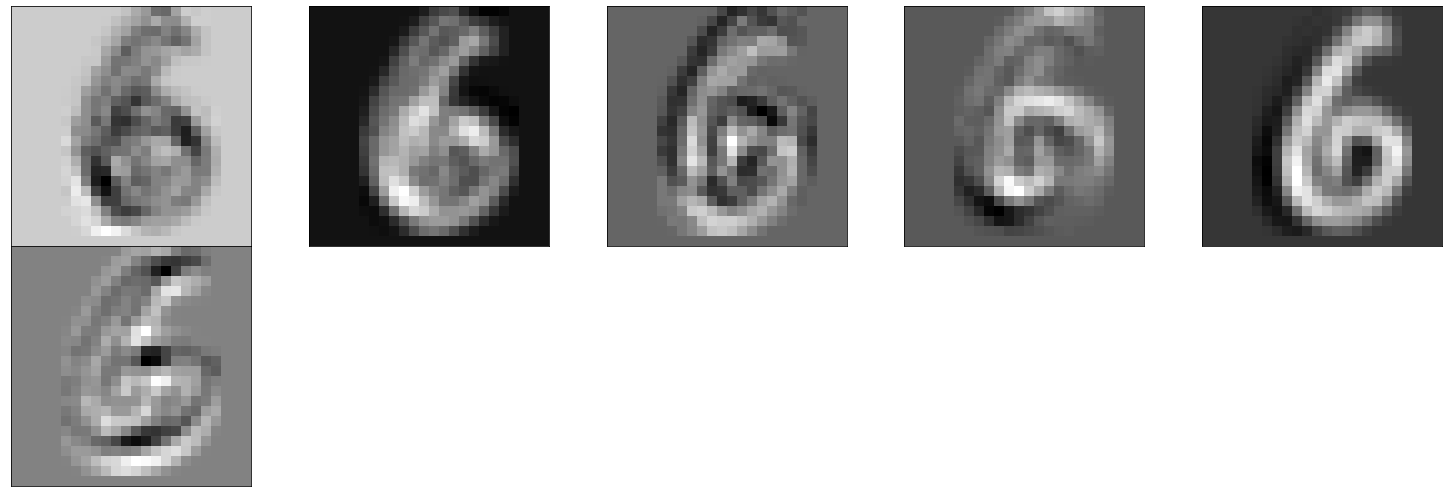

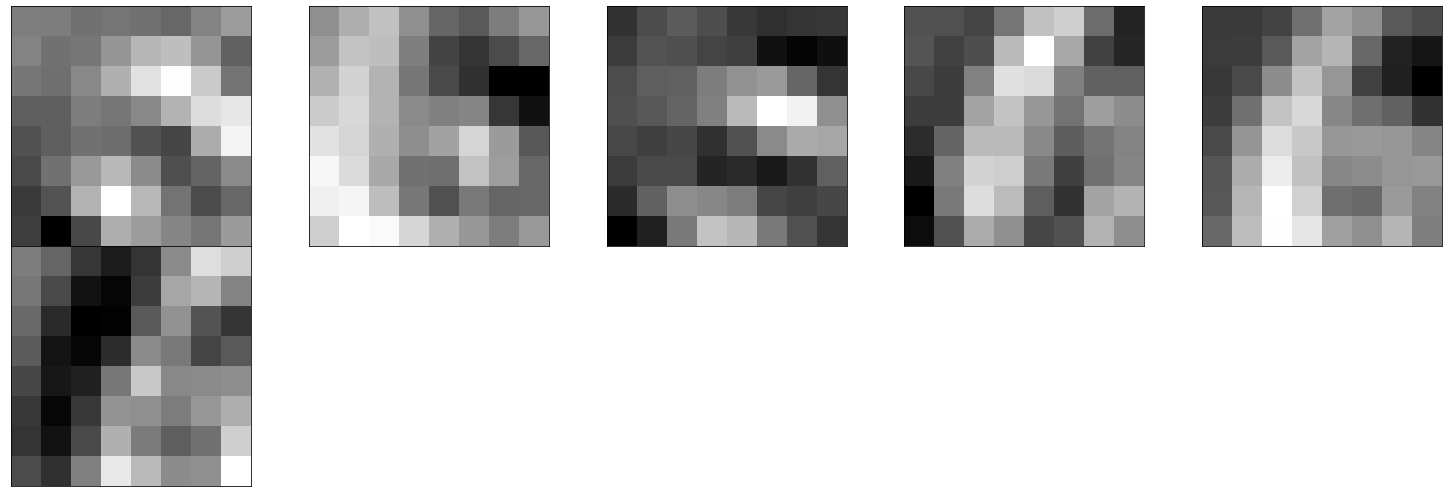

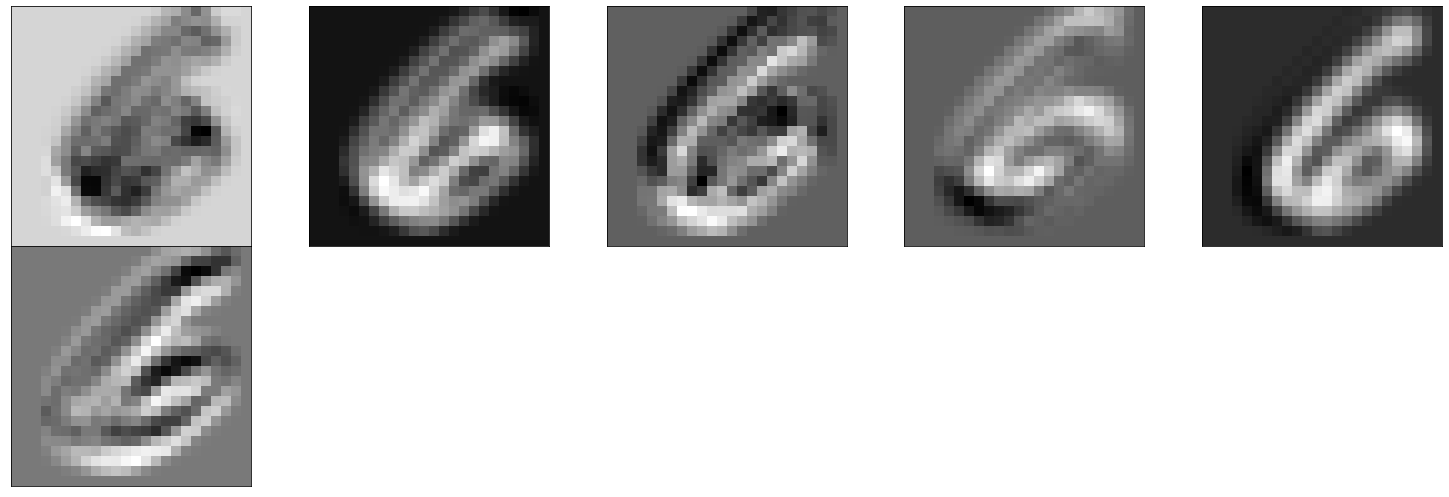

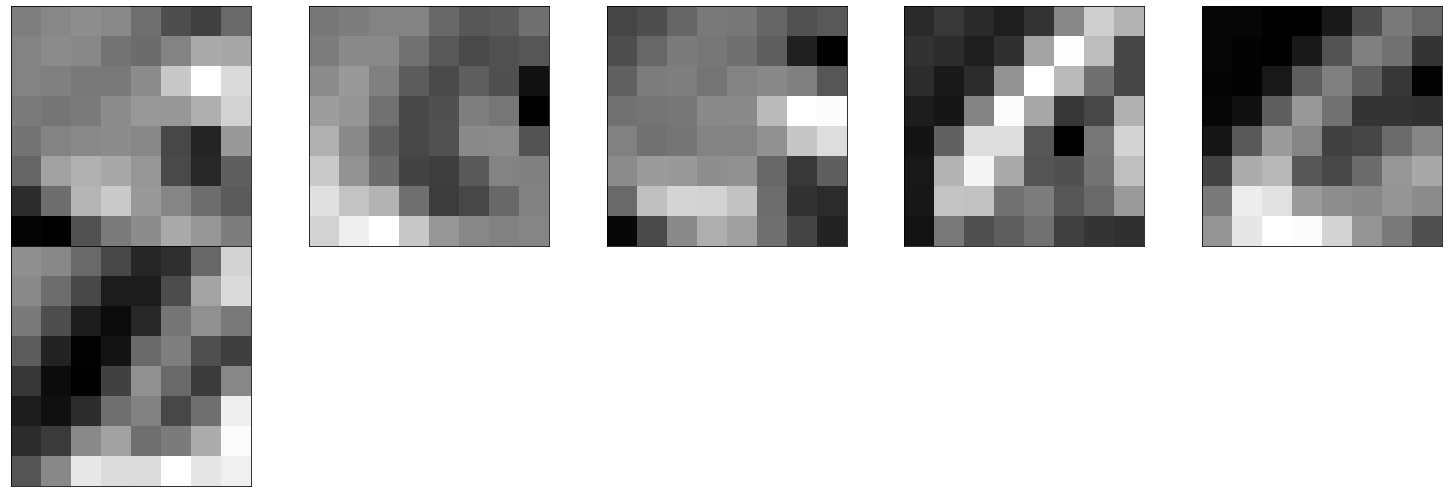

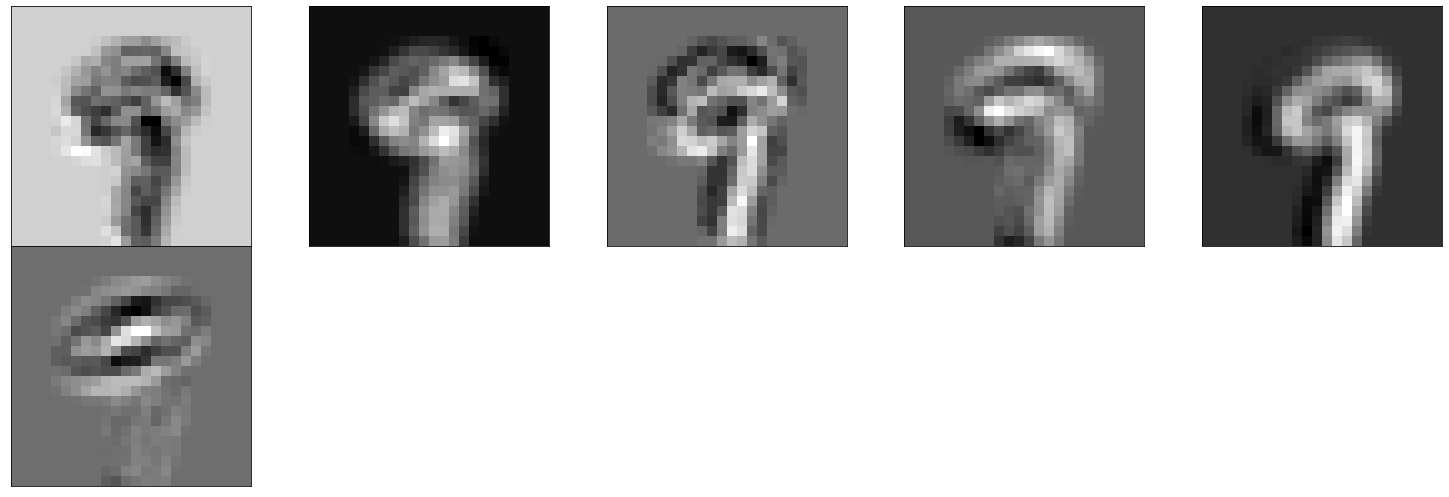

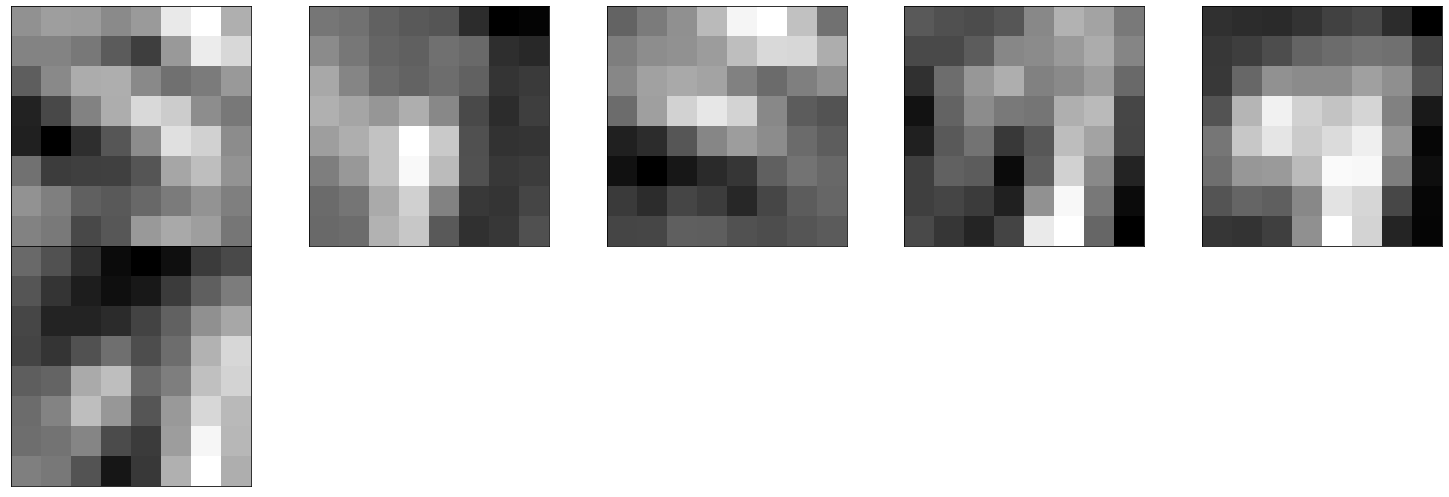

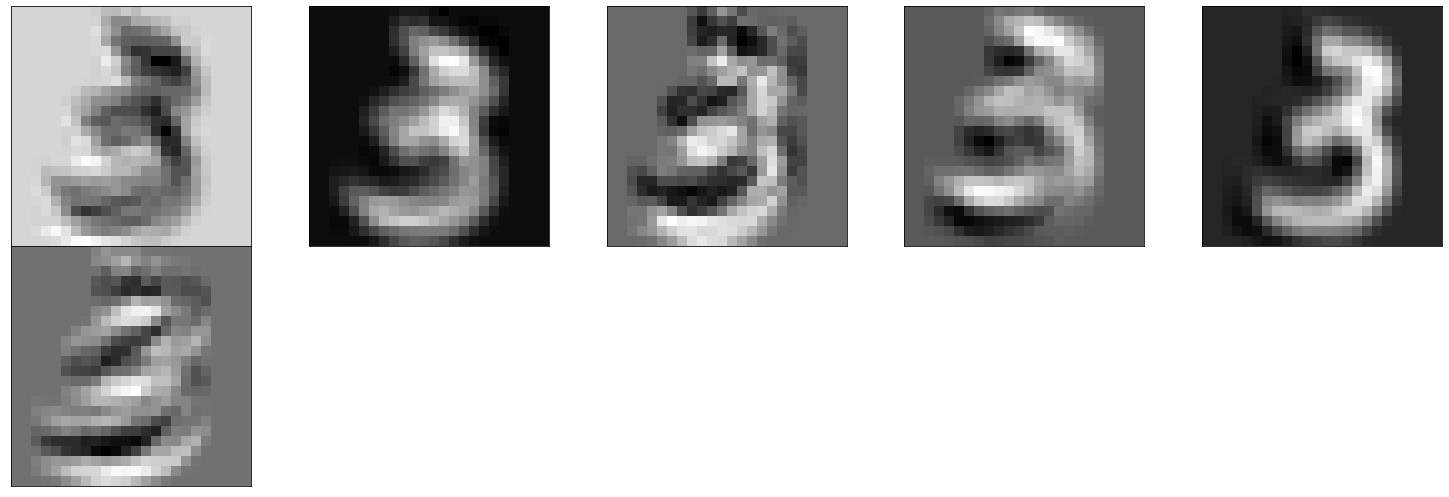

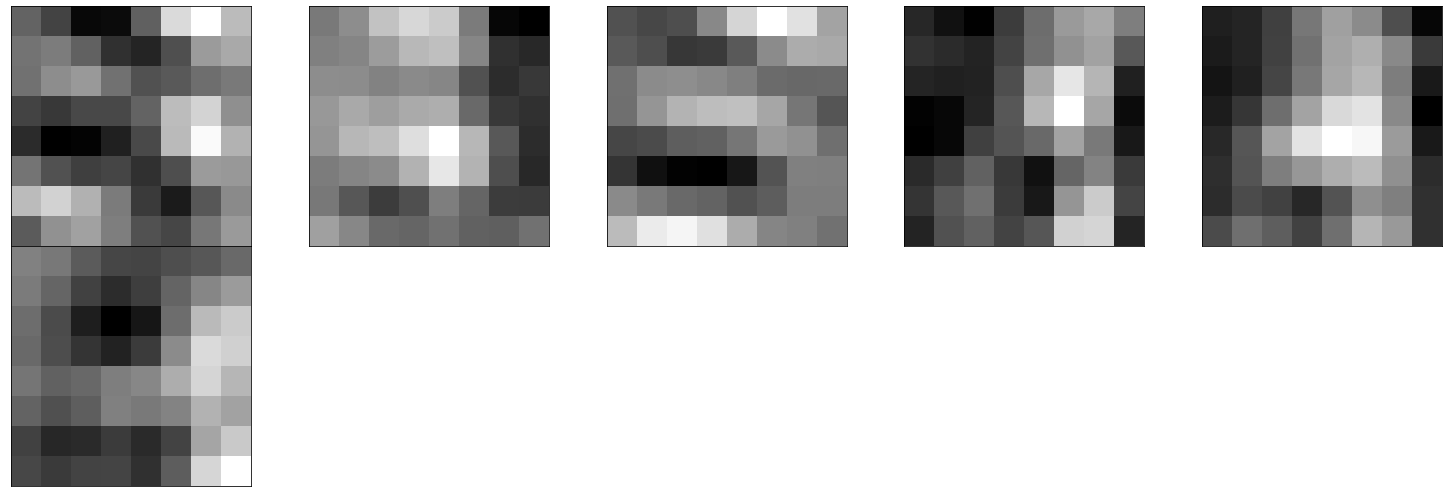

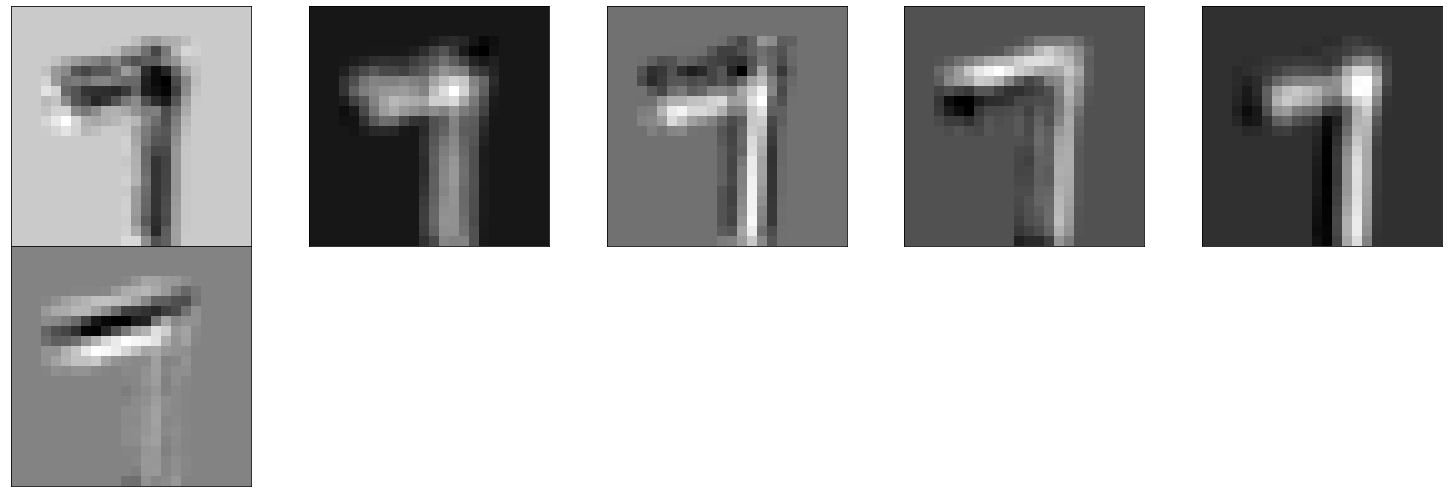

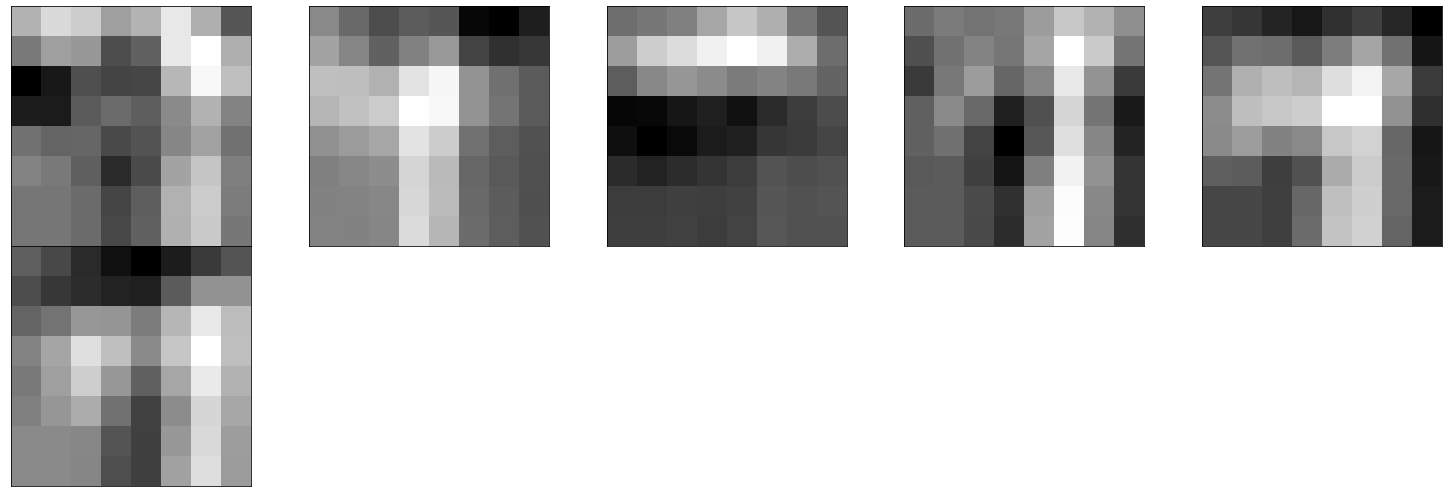

In [16]:
for images, targets in test_loader:
    #insert here your code
    act=getActivations(model_cnn, model_cnn.conv1, images.to(device))
    act2=getActivations(model_cnn, model_cnn.conv2, images.to(device))
    
    fig = plt.figure(figsize=(20,50))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0, wspace=0.2)
    for i in range(n_features):
        ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
        ax.imshow(act[0][i].cpu().detach().numpy(), cmap=plt.get_cmap('gray'))

    fig = plt.figure(figsize=(20,50))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0, wspace=0.2)
    for i in range(n_features):
        ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
        ax.imshow(act2[0][i].cpu().detach().numpy(), cmap=plt.get_cmap('gray'))

## A more challenging dataset

The MNIST dataset is relatively simple to solve as you can see from the score obtained above. Let's take a look to a more challenging task such as <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR-10</a>. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [22]:
input_size  = 32*32   # images are 32x32 pixels
output_size = 10      # there are 10 classes

transform=transforms.Compose([ #normalization on 3 channels
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

dataset_tr = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
dataset_te = datasets.CIFAR10('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset_tr,batch_size=100,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_te, batch_size=1000,shuffle=True)

#load training data
images, labels = next(iter(train_loader))

Files already downloaded and verified


>**Task 6:** adapt the CNN developed for MNIST on the CIFAR-10 dataset and look at the results. Notice that the CIFAR images use 3 channels (RGB) instead of 1 channel (black and white). Run 2 epochs.

In [31]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        #insert your code here
        K=5 #Kernel size
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=K)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=K)
        self.fc1 = nn.Linear(n_feature*5*5, 50)
        self.fc2 = nn.Linear(50, 10)
        
        
    def forward(self, x, verbose=False):
        #initial dimensions for x will be [100, 3, 32, 32]
        #insert your code here
        x = self.conv1(x) #[100, 6, 28, 28]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #[100, 6, 14, 14]
        x = self.conv2(x) #[100, 6, 10, 10]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #[100, 6, 5, 5]
        x = x.view(-1, self.n_feature*5*5) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 1):
    train(model_cnn, device, train_loader, optimizer, epoch)
    test(model_cnn, device, test_loader)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.320993
Train Epoch: 0 [10000/50000 (20%)]	Loss: 2.282355
Train Epoch: 0 [20000/50000 (40%)]	Loss: 2.256254
Train Epoch: 0 [30000/50000 (60%)]	Loss: 2.086547
Train Epoch: 0 [40000/50000 (80%)]	Loss: 2.045473

Test set: Average loss: 1.9246, Accuracy: 3019/10000 (30%)



>**Task 7:** Use your intuition to improve the accuracy of the network. You may vary any parameter and the architecture of the network as you wish

possible options:

- modify the learning rate and/or optimization method
- adding more linear layers on the final classification
- alter the number of channels
- change kernel sizes
- more epochs

unfortunately the size of images is quite small so adding more convolutional layers wouldn't help as the final features would shring to kust 1 or 2 pixels
